In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.cluster.hierarchy as shc

import matplotlib.pylab as plt
plt.style.use("ggplot") 

from sklearn.manifold import TSNE
from wordcloud import WordCloud
from scipy.sparse import csr_matrix
import json

import sys
sys.setrecursionlimit(10000)

import data_helpers
import data_titles_helpers
from data_helpers import *
from data_titles_helpers import *
import imp
imp.reload(data_helpers)
imp.reload(data_titles_helpers)

<module 'data_titles_helpers' from '/Users/kyrylo/Projects/personal/thesis/data_titles_helpers.py'>

# Users

In [2]:
df_users = pd.read_csv(NEW_USERS_PATH)
df_se_skills = pd.read_csv(PREPROCESSED_SE_SKILLS_PATH)
df_countries = pd.read_csv(PREPROCESSED_COUNTRIES_PATH)
df_specialities = pd.read_csv(PREPROCESSED_SPECIALITIES_PATH)
df_users.describe(include='all')

ID                COUNTRY_ID  \
count                      91647                     91647   
unique                     91647                       143   
top     76d4832100218d3deeddaf25  b8214d929b3ec7b0548c1ac5   
freq                           1                     21715   
mean                         NaN                       NaN   
std                          NaN                       NaN   
min                          NaN                       NaN   
25%                          NaN                       NaN   
50%                          NaN                       NaN   
75%                          NaN                       NaN   
max                          NaN                       NaN   

       LAST_POSITION_TITLE SKILLS             SPECIALITY_ID  \
count                86377  91647                     91647   
unique               23373  69430                         3   
top      Software Engineer     []  ef2aa0915a3bf179755b8915   
freq                  2232   1977                     60202   
mean                   NaN    NaN                       NaN   
std                    NaN    NaN                       NaN   
min                    NaN    NaN                       NaN   
25%                    NaN    NaN                       NaN   
50%                    NaN    NaN                       NaN   
75%                    NaN    NaN                       NaN   
max                    NaN    NaN                       NaN   

             MATCHING_PROFILE_ID     SENIORITY  
count                      91647  91647.000000  
unique                     91647           NaN  
top     76d4832100218d3deeddaf25           NaN  
freq                           1           NaN  
mean                         NaN      2.223597  
std                          NaN      0.918628  
min                          NaN      0.000000  
25%                          NaN      1.000000  
50%                          NaN      3.000000  
75%                          NaN      3.000000  
max                          NaN      3.000000

# Software engineers (SE) profiles

## Filter by speciality

In [3]:
# ML_SPECIALITY_ID
df_se_profiles = df_users[df_users[USER_SPECIALITY_ID_LABEL].apply(lambda id: id in [SE_SPECIALITY_ID])].copy()
df_se_profiles = df_se_profiles[[USER_ID_LABEL, USER_COUNTRY_ID_LABEL, USER_LAST_POSITION_TITLE_LABEL,USER_SKILLS_LABEL,USER_SPECIALITY_ID_LABEL, USER_SENIORITY_LABEL]]
df_se_profiles.drop(df_se_profiles[df_se_profiles[USER_SKILLS_LABEL] == '[]'].index, inplace=True)
df_se_profiles.drop_duplicates(subset=[USER_ID_LABEL], keep='last', inplace=True)
df_se_profiles.reset_index(drop=True, inplace=True)
df_se_profiles.describe(include='all')

ID                COUNTRY_ID  \
count                      59403                     59403   
unique                     59403                       132   
top     76d4832100218d3deeddaf25  b8214d929b3ec7b0548c1ac5   
freq                           1                     14315   
mean                         NaN                       NaN   
std                          NaN                       NaN   
min                          NaN                       NaN   
25%                          NaN                       NaN   
50%                          NaN                       NaN   
75%                          NaN                       NaN   
max                          NaN                       NaN   

       LAST_POSITION_TITLE                        SKILLS  \
count                57760                         59403   
unique               13429                         47068   
top      Software Engineer  ["06fcb2c5fb939f4855b3c9b5"]   
freq                  2167                           262   
mean                   NaN                           NaN   
std                    NaN                           NaN   
min                    NaN                           NaN   
25%                    NaN                           NaN   
50%                    NaN                           NaN   
75%                    NaN                           NaN   
max                    NaN                           NaN   

                   SPECIALITY_ID     SENIORITY  
count                      59403  59403.000000  
unique                         1           NaN  
top     ef2aa0915a3bf179755b8915           NaN  
freq                       59403           NaN  
mean                         NaN      2.277747  
std                          NaN      0.878196  
min                          NaN      0.000000  
25%                          NaN      2.000000  
50%                          NaN      3.000000  
75%                          NaN      3.000000  
max                          NaN      3.000000

<AxesSubplot:>

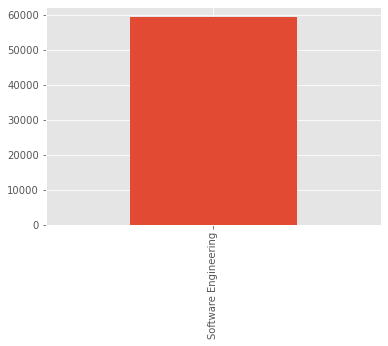

In [4]:
df_se_profiles[SPECIALITY_NAME_LABEL] = df_se_profiles.apply(lambda row: get_speciality_name_by_id(row[USER_SPECIALITY_ID_LABEL], df_specialities), axis=1)
df_se_profiles.drop(columns=[USER_SPECIALITY_ID_LABEL], inplace=True)

df_se_profiles[SPECIALITY_NAME_LABEL].value_counts().plot(kind='bar')

## Filter by seniority

In [5]:
df_se_profiles[USER_SENIORITY_LABEL].value_counts().plot(kind='bar')
plt.show()

df_se_profiles = restore_seniority_from_title(df_se_profiles, USER_SENIORITY_LABEL, USER_LAST_POSITION_TITLE_LABEL, 2)

df_se_profiles[USER_SENIORITY_LABEL].value_counts().plot(kind='bar')

Restored results:
0    1327
1     181
3       6
Name: LAST_POSITION_TITLE, dtype: int64


<AxesSubplot:>

### Top countries

In [6]:
top_countries_ids = [id for id in df_se_profiles[USER_COUNTRY_ID_LABEL].value_counts()[df_se_profiles[USER_COUNTRY_ID_LABEL].value_counts() > MIN_NUMBER_OF_USERS_IN_COUNTRY].index] 
top_countries = [get_country_code_by_id(id, df_countries) for id in top_countries_ids]
top_countries

['EE', 'LT', 'FI', 'DE', 'PK', 'LV']

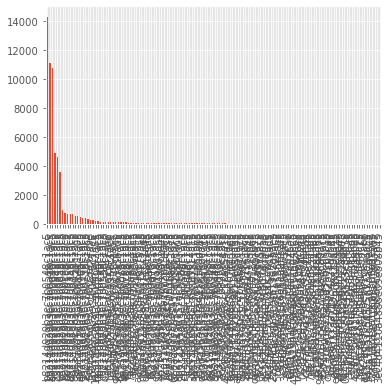

<AxesSubplot:>

In [7]:
df_se_profiles[USER_COUNTRY_ID_LABEL].value_counts().plot(kind='bar')
plt.show()

df_se_profiles = df_se_profiles[df_se_profiles[USER_COUNTRY_ID_LABEL].isin(top_countries_ids)].copy()
df_se_profiles[USER_COUNTRY_CODE_LABEL] = df_se_profiles[USER_COUNTRY_ID_LABEL].apply(lambda country_id: get_country_code_by_id(country_id, df_countries))

df_se_profiles.drop(columns=[USER_COUNTRY_ID_LABEL], inplace=True)
df_se_profiles.reset_index(drop=True, inplace=True)

df_se_profiles[USER_COUNTRY_CODE_LABEL].value_counts().plot(kind='bar')

In [8]:
df_se_profiles.describe(include='all')

ID LAST_POSITION_TITLE  \
count                      49262               47909   
unique                     49262               11026   
top     e94041f13061f222f9e06c35  Software developer   
freq                           1                1889   
mean                         NaN                 NaN   
std                          NaN                 NaN   
min                          NaN                 NaN   
25%                          NaN                 NaN   
50%                          NaN                 NaN   
75%                          NaN                 NaN   
max                          NaN                 NaN   

                              SKILLS     SENIORITY       SPECIALITY_NAME  \
count                          49262  49262.000000                 49262   
unique                         38430           NaN                     1   
top     ["06fcb2c5fb939f4855b3c9b5"]           NaN  Software Engineering   
freq                             241           NaN                 49262   
mean                             NaN      2.323393                   NaN   
std                              NaN      0.801242                   NaN   
min                              NaN      1.000000                   NaN   
25%                              NaN      2.000000                   NaN   
50%                              NaN      3.000000                   NaN   
75%                              NaN      3.000000                   NaN   
max                              NaN      3.000000                   NaN   

       COUNTRY_CODE  
count         49262  
unique            6  
top              EE  
freq          14315  
mean            NaN  
std             NaN  
min             NaN  
25%             NaN  
50%             NaN  
75%             NaN  
max             NaN

## Filter by number of skills

In [9]:
df_se_profiles_skills = get_users_skills_df(df_se_profiles, df_se_skills)
df_se_profiles.drop(columns=[USER_SKILLS_LABEL], inplace=True, errors='ignore')

df_se_profiles_skills[SKILL_USER_ID_LABEL] = [get_user_id_by_index(index, df_se_profiles) for index in df_se_profiles_skills.index]
df_se_profiles_skills.set_index(SKILL_USER_ID_LABEL, inplace=True)

df_se_profiles_skills_real_names = df_se_profiles_skills.copy()
df_se_profiles_skills_real_names.columns = [get_skill_name_by_index(index, df_se_skills) for index in df_se_profiles_skills.columns]


df_se_profiles_skills.columns = [get_skill_tag_by_index(index, df_se_skills) for index in df_se_profiles_skills.columns]

df_se_profiles_skills

programming_language__abap  \
USER_ID                                                
e66911f13061f2226be06c25                           0   
276911f13061f2226be06c25                           0   
e76911f13061f2226be06c25                           0   
f8343b8716ee6a873cfa2dc5                           0   
296911f13061f2226be06c25                           0   
...                                              ...   
b84f51314621231076abb0a6                           0   
cdc8b721001fb2a006ab6046                           0   
b815b8210041de70e6ab2046                           0   
338ae221006aa1a057ab5046                           0   
e065fd210058bbe077ab2046                           0   

                          programming_language__bash  \
USER_ID                                                
e66911f13061f2226be06c25                           0   
276911f13061f2226be06c25                           0   
e76911f13061f2226be06c25                           0   
f8343b8716ee6a873cfa2dc5                           0   
296911f13061f2226be06c25                           0   
...                                              ...   
b84f51314621231076abb0a6                           0   
cdc8b721001fb2a006ab6046                           0   
b815b8210041de70e6ab2046                           0   
338ae221006aa1a057ab5046                           0   
e065fd210058bbe077ab2046                           0   

                          programming_language__c_cpp  \
USER_ID                                                 
e66911f13061f2226be06c25                            0   
276911f13061f2226be06c25                            0   
e76911f13061f2226be06c25                            0   
f8343b8716ee6a873cfa2dc5                            0   
296911f13061f2226be06c25                            0   
...                                               ...   
b84f51314621231076abb0a6                            0   
cdc8b721001fb2a006ab6046                            0   
b815b8210041de70e6ab2046                            0   
338ae221006aa1a057ab5046                            0   
e065fd210058bbe077ab2046                            0   

                          programming_language__clojure  \
USER_ID                                                   
e66911f13061f2226be06c25                              0   
276911f13061f2226be06c25                              0   
e76911f13061f2226be06c25                              0   
f8343b8716ee6a873cfa2dc5                              0   
296911f13061f2226be06c25                              0   
...                                                 ...   
b84f51314621231076abb0a6                              0   
cdc8b721001fb2a006ab6046                              0   
b815b8210041de70e6ab2046                              0   
338ae221006aa1a057ab5046                              0   
e065fd210058bbe077ab2046                              0   

                          programming_language__csharp  \
USER_ID                                                  
e66911f13061f2226be06c25                             0   
276911f13061f2226be06c25                             0   
e76911f13061f2226be06c25                             1   
f8343b8716ee6a873cfa2dc5                             0   
296911f13061f2226be06c25                             0   
...                                                ...   
b84f51314621231076abb0a6                             0   
cdc8b721001fb2a006ab6046                             0   
b815b8210041de70e6ab2046                             0   
338ae221006aa1a057ab5046                             0   
e065fd210058bbe077ab2046                             0   

                          programming_language__dart  \
USER_ID                                                
e66911f13061f2226be06c25                           0   
276911f13061f2226be06c25                           0   
e76911f13061f2226be06c25                           0   
f8343b8716ee6a873cfa2dc

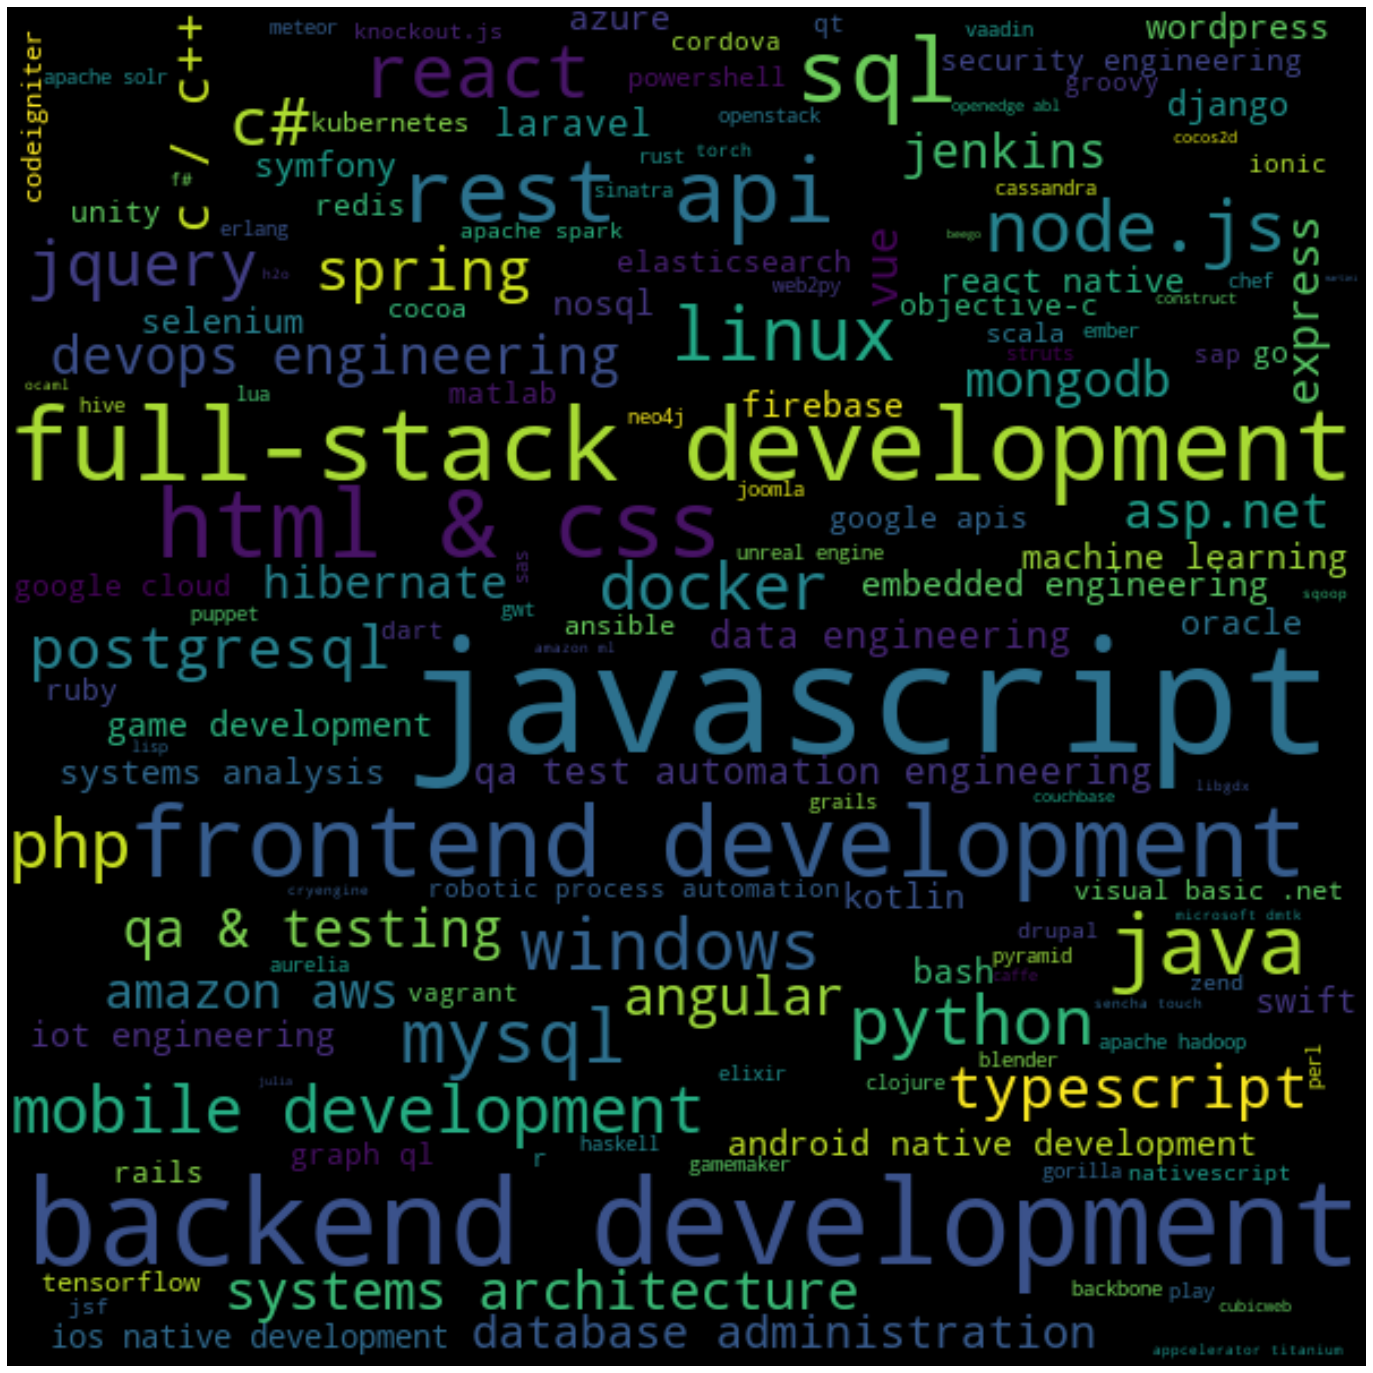

In [10]:
wc = WordCloud(width=600, height=600).generate_from_frequencies(df_se_profiles_skills_real_names.sum())
plt.figure(figsize=(25, 25))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

## Filter by skill occurrences

In [11]:
plot_top_skills(df_se_profiles_skills, df_se_skills, skill_label=SKILL_TAG_LABEL, n=df_se_profiles_skills.shape[1])

In [12]:
df_se_profiles_skills = df_se_profiles_skills.loc[(df_se_profiles_skills.sum(axis=1) != 0), (df_se_profiles_skills.sum(axis=0) != 0)]

In [13]:
print('SE Profiles skills shape:', df_se_profiles_skills.shape)
print('SE Profiles shape:', df_se_profiles.shape)
print('Unique skill names:', len(list(df_se_profiles_skills.columns.sort_values().unique())))

SE Profiles skills shape: (48833, 153)
SE Profiles shape: (49262, 5)
Unique skill names: 153


## Output

In [14]:
df_se_profiles_skills_out = df_se_profiles_skills.copy()
df_se_profiles_out = df_se_profiles.copy()

df_se_profiles_out.set_index(USER_ID_LABEL, inplace=True)
df_se_profiles_out = pd.concat([df_se_profiles_skills, df_se_profiles_out], axis=1).dropna()
df_se_profiles_out.index.name = USER_ID_LABEL

df_se_profiles_out.to_csv(PREPROCESSED_SE_PROFILES_PATH)
df_se_profiles_skills_out.to_csv(PREPROCESSED_SE_PROFILES_SKILLS_PATH)

play_sound()